# Step 5: Find matches within a search radius

In [28]:
from functools import partial
import numpy as np
import os
from phathom.utils import pickle_load, read_voxel_size
from phathom.registration.coarse import rigid_transformation
from phathom.registration.pcloud import radius_matching, rotation_matrix
from phathom import plotting

In [29]:
working_dir = '/home/jswaney/org_registration/'

In [30]:
# Load blobs
fixed_blobs_path = 'round1/blobs.npy'
moving_blobs_path = 'round2/blobs.npy'

fixed_blobs = np.load(os.path.join(working_dir, 
                                   fixed_blobs_path))
moving_blobs = np.load(os.path.join(working_dir, 
                                    moving_blobs_path))
print('keypoints:', fixed_blobs.shape, moving_blobs.shape)

keypoints: (651491, 3) (504499, 3)


In [34]:
# Load features
fixed_features_path = 'round1/features.npy'
moving_features_path = 'round2/features.npy'

fixed_feat = np.load(os.path.join(working_dir, 
                                  fixed_features_path))
moving_feat = np.load(os.path.join(working_dir, 
                                   moving_features_path))
print('features:', fixed_feat.shape, moving_feat.shape)

features: (651491, 6) (504499, 6)


In [31]:
# Load the rigid transformation
transformation_path = 'rigid_transformation.pkl'

transformation_dict = pickle_load(os.path.join(working_dir, 
                                               transformation_path))
t = transformation_dict['t']
center = transformation_dict['center']
theta = transformation_dict['theta']
s = transformation_dict['s']
print('Loaded rigid transformation for original image')
print('Rotation (deg):', theta*180/np.pi)
print('Center (px):', center)
print('Translation (px):', t)
print('Scale Factor:', s)

Loaded rigid transformation for original image
Rotation (deg): [  13.50912262  -11.09083109  184.0845952 ]
Center (px): [  245.18793636  1121.12106598  1064.74718654]
Translation (px): [  19.36382414  -77.66485791 -263.8800804 ]
Scale Factor: 0.916566242381


In [32]:
# Roghly align fixed_pts
r = rotation_matrix(theta)
transformation = partial(rigid_transformation, t=t, r=r, center=center, s=s)
transformed_pts = transformation(pts=fixed_blobs)
transformed_pts.shape

(651491, 3)

In [33]:
# Save coarse aligned pts
np.save(os.path.join(working_dir, 'round1/blobs_coarse.npy'), transformed_pts)

In [35]:
# Convert to micron
voxel_size_path = 'voxel_size.txt'

voxel_size = read_voxel_size(os.path.join(working_dir, voxel_size_path))
voxel_size

(2.052, 1.082, 1.082)

In [36]:
transformed_pts_um = np.asarray(voxel_size) * transformed_pts
moving_pts_um = np.asarray(voxel_size) * moving_blobs

<IPython.core.display.Javascript object>


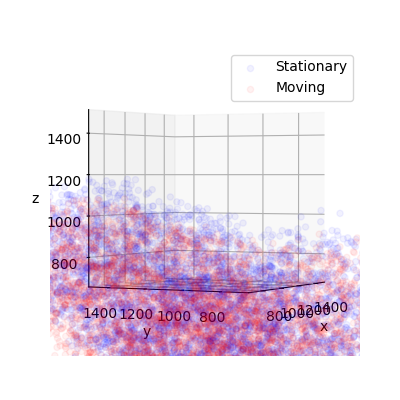

In [37]:
%matplotlib notebook
nb_pts = 5000

moving_idx = np.arange(moving_blobs.shape[0])
np.random.shuffle(moving_idx)
transformed_idx = np.arange(transformed_pts.shape[0])
np.random.shuffle(transformed_idx)

plotting.plot_pts(moving_pts_um[moving_idx[:nb_pts]], transformed_pts_um[transformed_idx[:nb_pts]], alpha=0.05)

In [38]:
# Match to moving_pts within search radius
radius = 200
nb_workers = None
batch_size = 20000
matching_kwargs = {'max_fdist': 1,
                   'prom_thresh': 0.2}

idx_fixed, idx_moving = radius_matching(transformed_pts_um, 
                                        moving_pts_um, 
                                        fixed_feat, 
                                        moving_feat, 
                                        radius, 
                                        nb_workers, 
                                        batch_size, 
                                        matching_kwargs)
print('Found {} matches'.format(idx_fixed.shape[0]))

Found 72 matches


In [39]:
# Save matching indices
fixed_idx_path = 'round1/match_idx.npy'
moving_idx_path = 'round2/match_idx.npy'

np.save(os.path.join(working_dir, fixed_idx_path), idx_fixed)
np.save(os.path.join(working_dir, moving_idx_path), idx_moving)